In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')

c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Reading data from a concatenated file

In [2]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Data splitting

In [3]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Preliminary data analysis

In [4]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [5]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household,Total
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000,265193.600000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866,2669.521923
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000,262058.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000,263457.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000,264696.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000,267174.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


### 3. Model creation

We have created two models: 
- the first model predicts the number of individuals after marriage based on data about average household income per member, 
- the second model additionally utilizes the number of available housing units and the average age of entering first marriage.

We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model 1:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- Linear equation: f (income) = $\alpha$*income + $\beta$
- Sampling: y (income) = 

Model 2:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of available housing units, average age of first marriage
- równanie...




##### Differences
Despite highly correlated features, adding additional parameters makes sense as it complicates the equation but does not significantly impact the prediction. The impact is smaller, but the difference is noticeable.

In [6]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

##### Prior parameters selection
The prior parameters were chosen by fitting a function that closely resembled the trend of marriages over the years. In this case, it turned out to be a linear function (for the first model) or closely approximated a linear function within this range (for the second model).

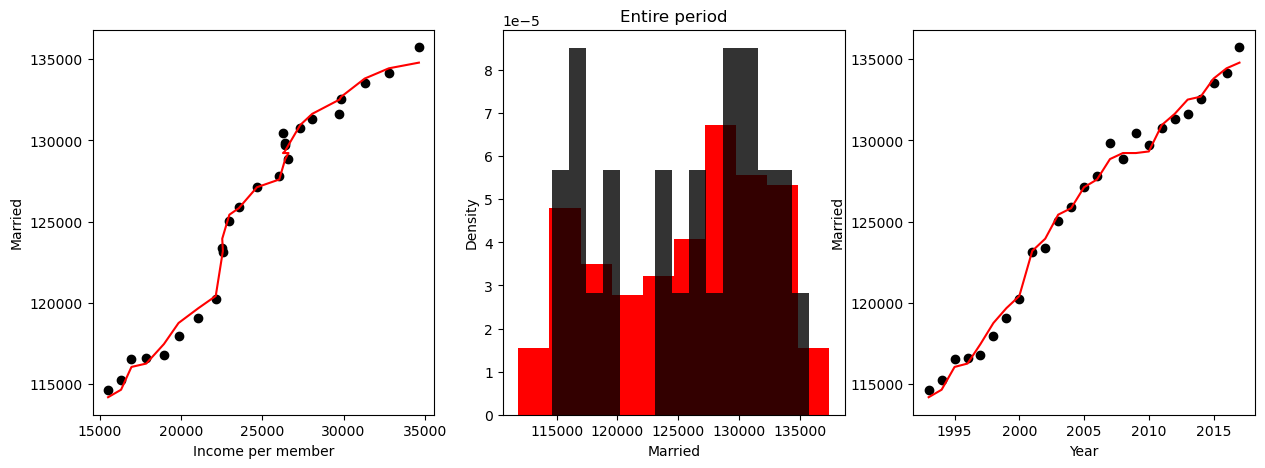

In [7]:
# Parameters testing for Model 2

# Sample data
x = df['Income per member']
y = df['Household']
z = df['Mean age']

c = df['Married']
sigma = 1000

X = np.column_stack((np.ones_like(x), x, y, z))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, c, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y, slope_z = coefficients

# Define points for the plane
z_plane = slope_x * x + slope_y * y + slope_z * z + intercept 

intercept, slope_x, slope_y, slope_z


plt.figure(figsize=(15,5))


plt.subplot(1,3,1)
plt.scatter(df['Income per member'], df['Married'], color="black")
plt.plot(df['Income per member'], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(1,3,2)
sim = random.normal(slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, sigma, (100,25))

for i in range(len(sim)):
    plt.hist(sim.flatten().tolist(), color='red', alpha = 0.3, density=True)

plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')


plt.subplot(1,3,3)
plt.scatter(df["Year"], df['Married'], color="black")
plt.plot(df["Year"], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Year')
plt.ylabel('Married')


plt.show()

#### 4.1. Model 1.

In [8]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:24:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


14:24:30 - cmdstanpy - INFO - CmdStan done processing.


In [9]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,363.866,117641.0,118205.0,119694.0,121310.0,123219.0,...,133201.0,132597.0,132819.0,134335.0,135459.0,137393.0,137668.0,139021.0,141757.0,144066.0
1,0.0,0.0,1.31904,94585.6,920.009,115618.0,116481.0,114319.0,119083.0,120051.0,...,129924.0,127965.0,128886.0,130385.0,132314.0,134090.0,134564.0,134769.0,137831.0,140274.0
2,0.0,0.0,1.32074,95939.3,1369.850,118025.0,119129.0,119395.0,120566.0,118716.0,...,129258.0,131617.0,133192.0,131577.0,130381.0,135740.0,135535.0,135992.0,140704.0,141658.0
3,0.0,0.0,1.27851,93917.6,1448.920,114407.0,113572.0,115352.0,113999.0,116686.0,...,126430.0,127360.0,129535.0,128749.0,129187.0,130304.0,130324.0,135987.0,135567.0,137973.0
4,0.0,0.0,1.29026,95390.9,1441.340,112325.0,116740.0,113999.0,117546.0,118565.0,...,128488.0,129924.0,130377.0,131357.0,129797.0,135208.0,134845.0,134200.0,139138.0,140197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.31033,94430.7,532.655,114351.0,115648.0,116806.0,118602.0,119131.0,...,128824.0,129325.0,128700.0,130701.0,131043.0,133783.0,133867.0,134757.0,136749.0,139112.0
96,0.0,0.0,1.22993,95747.7,809.024,115040.0,117460.0,115017.0,116284.0,119614.0,...,127486.0,128632.0,128578.0,128741.0,129549.0,132029.0,132914.0,133563.0,136398.0,138342.0
97,0.0,0.0,1.32200,94757.8,1203.580,115430.0,117106.0,117174.0,120095.0,117182.0,...,130557.0,130432.0,130465.0,130598.0,132245.0,134293.0,134099.0,135852.0,138473.0,139727.0
98,0.0,0.0,1.21926,93646.4,504.891,112591.0,114202.0,115266.0,116211.0,116792.0,...,126088.0,125178.0,126235.0,127169.0,127822.0,129899.0,129907.0,132067.0,133500.0,135687.0


#### 4.2. Model 2.

In [10]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:24:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


14:24:31 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.014708,0.817772,1254.55,68755.2,30.5289,115825.0,116326.0,117783.0,...,131093.0,131115.0,131229.0,132848.0,133564.0,134408.0,134655.0,135764.0,136473.0,136791.0
1,0.0,0.0,0.011840,0.816388,1288.60,62824.4,151.7530,108921.0,109444.0,110657.0,...,124126.0,124052.0,124206.0,125565.0,126442.0,127327.0,127691.0,128748.0,129381.0,129800.0
2,0.0,0.0,0.013213,0.817903,1295.36,65232.6,213.5020,111550.0,111545.0,113237.0,...,126475.0,126247.0,126774.0,128185.0,128966.0,129649.0,130144.0,131181.0,131546.0,132043.0
3,0.0,0.0,0.010109,0.800013,1304.34,66800.5,85.4239,110869.0,111489.0,112641.0,...,125590.0,125581.0,125738.0,127315.0,128029.0,128628.0,128989.0,129878.0,130628.0,130948.0
4,0.0,0.0,0.012259,0.794668,1259.70,70734.9,75.3730,115375.0,115772.0,117214.0,...,130157.0,130192.0,130350.0,131875.0,132475.0,133480.0,133521.0,134659.0,135296.0,135759.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.010789,0.799298,1277.12,66982.7,130.9510,111696.0,112137.0,113748.0,...,126652.0,126402.0,126390.0,128281.0,128886.0,129672.0,129624.0,130905.0,131740.0,131847.0
96,0.0,0.0,0.012588,0.813148,1287.05,69854.7,173.8200,115592.0,116273.0,117584.0,...,130752.0,131016.0,130790.0,132424.0,133237.0,133995.0,134051.0,135283.0,136125.0,136335.0
97,0.0,0.0,0.013253,0.812071,1244.70,68002.4,17.0457,114736.0,115226.0,116606.0,...,129870.0,129919.0,130029.0,131646.0,132327.0,133246.0,133442.0,134560.0,135188.0,135601.0
98,0.0,0.0,0.011151,0.806342,1310.00,63997.8,129.9900,108454.0,108792.0,110407.0,...,123358.0,123377.0,123584.0,125314.0,126066.0,126668.0,126864.0,128147.0,128654.0,128956.0


##### Prior predictive checks for parameters

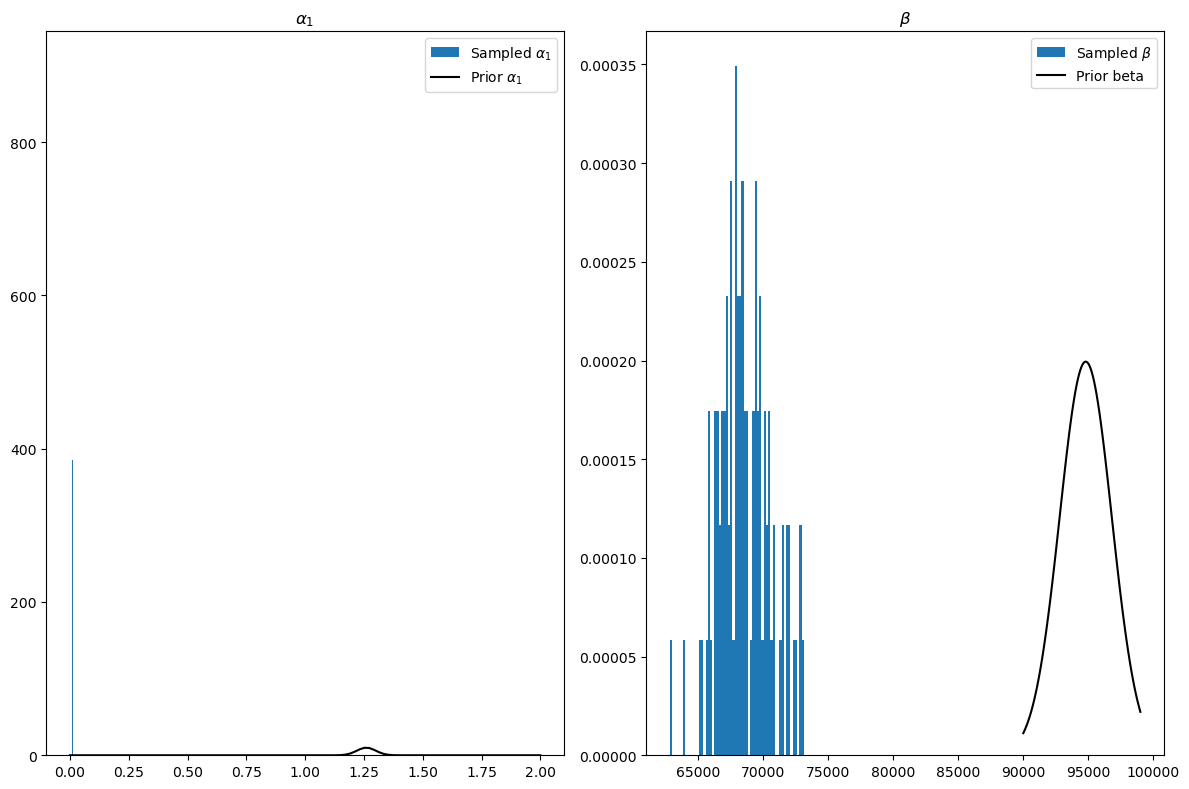

In [12]:
alpha1_pred = prior_2.stan_variable('alpha_1')
beta_pred= prior_2.stan_variable('beta')

fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)
x = np.linspace(0,2,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.04)
axes[0].hist(alpha1_pred, bins=60,label=r'Sampled $\alpha_1$',density=True)
axes[0].set_title(r'$\alpha_1$')
axes[0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0].legend()

x = np.linspace(90000, 99000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=2000)
axes[1].hist(beta_pred, bins=60,label=r'Sampled $\beta$',density=True)
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = 'Prior beta',color='k')
axes[1].legend()

##### Prior predictive checks for measurements

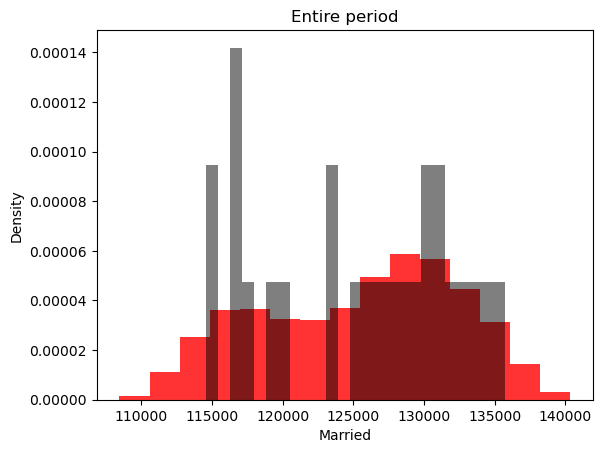

In [13]:
prior_2_combined = []
for i in range(R):
    prior_2_combined.extend(prior_2.y_sim[i])
plt.hist(prior_2_combined, bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

### 6. Posterior (model 2) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [14]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

14:24:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


14:24:33 - cmdstanpy - INFO - CmdStan done processing.


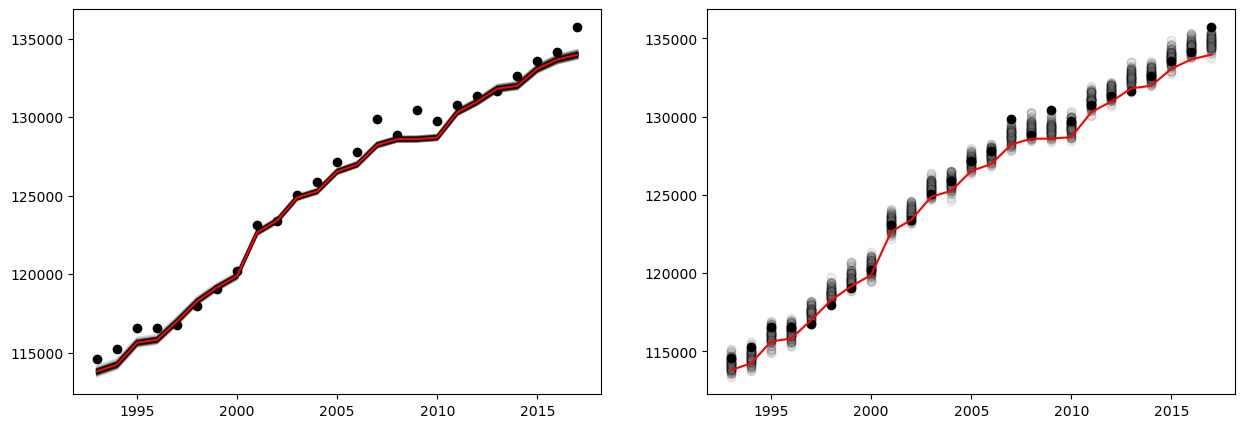

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], -post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [16]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-187.320000,0.224826,1.663530,-190.490000,-187.021000,-185.159000,54.7482,1955.29,0.990192
alpha_1,0.012056,0.000099,0.001009,0.010524,0.012067,0.013858,103.9620,3712.94,0.990658
alpha_2,0.810500,0.000881,0.006467,0.799441,0.810425,0.822361,53.8687,1923.88,0.990421
alpha_3,1279.240000,2.717340,19.896900,1247.260000,1277.810000,1317.640000,53.6144,1914.80,0.998864
beta,68478.700000,117.683000,830.024000,67064.100000,68638.300000,69873.000000,49.7452,1776.62,0.999024
sigma,359.056000,3.551760,28.002400,307.933000,362.685000,402.175000,62.1586,2219.95,1.005320
y_sim[1],114177.000000,36.183000,356.656000,113635.000000,114179.000000,114720.000000,97.1607,3470.02,0.996198
y_sim[2],114644.000000,42.793100,370.663000,113979.000000,114630.000000,115165.000000,75.0259,2679.50,0.992547
y_sim[3],116038.000000,38.015900,417.965000,115117.000000,116045.000000,116715.000000,120.8790,4317.09,0.989950
y_sim[4],116271.000000,41.930400,385.010000,115592.000000,116327.000000,116862.000000,84.3114,3011.12,0.995113


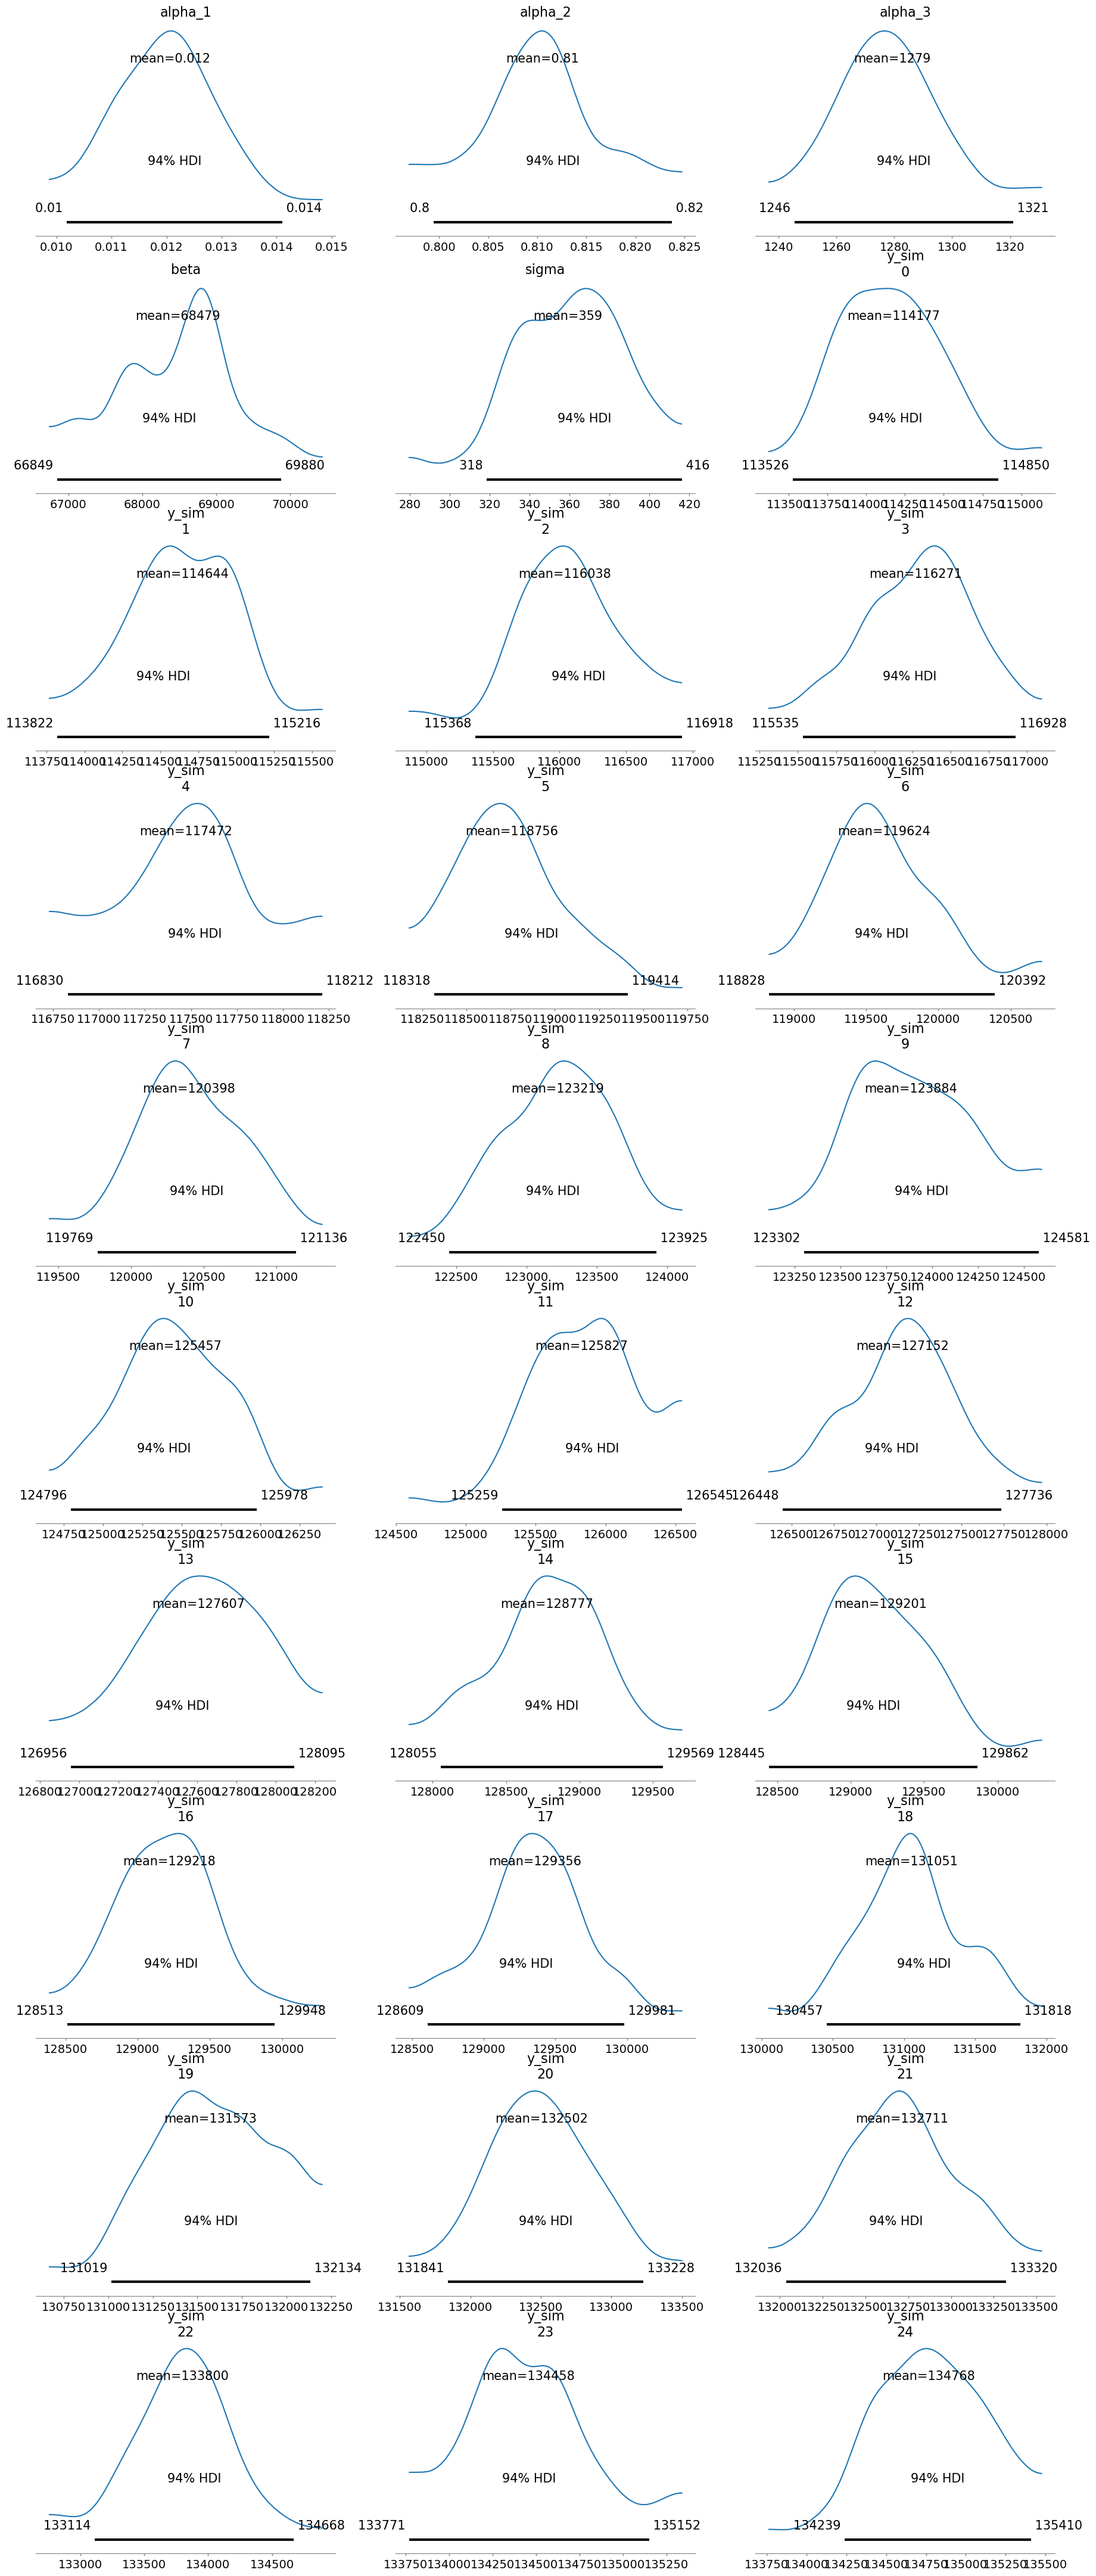

In [17]:
az.plot_posterior(post_2)
plt.show()

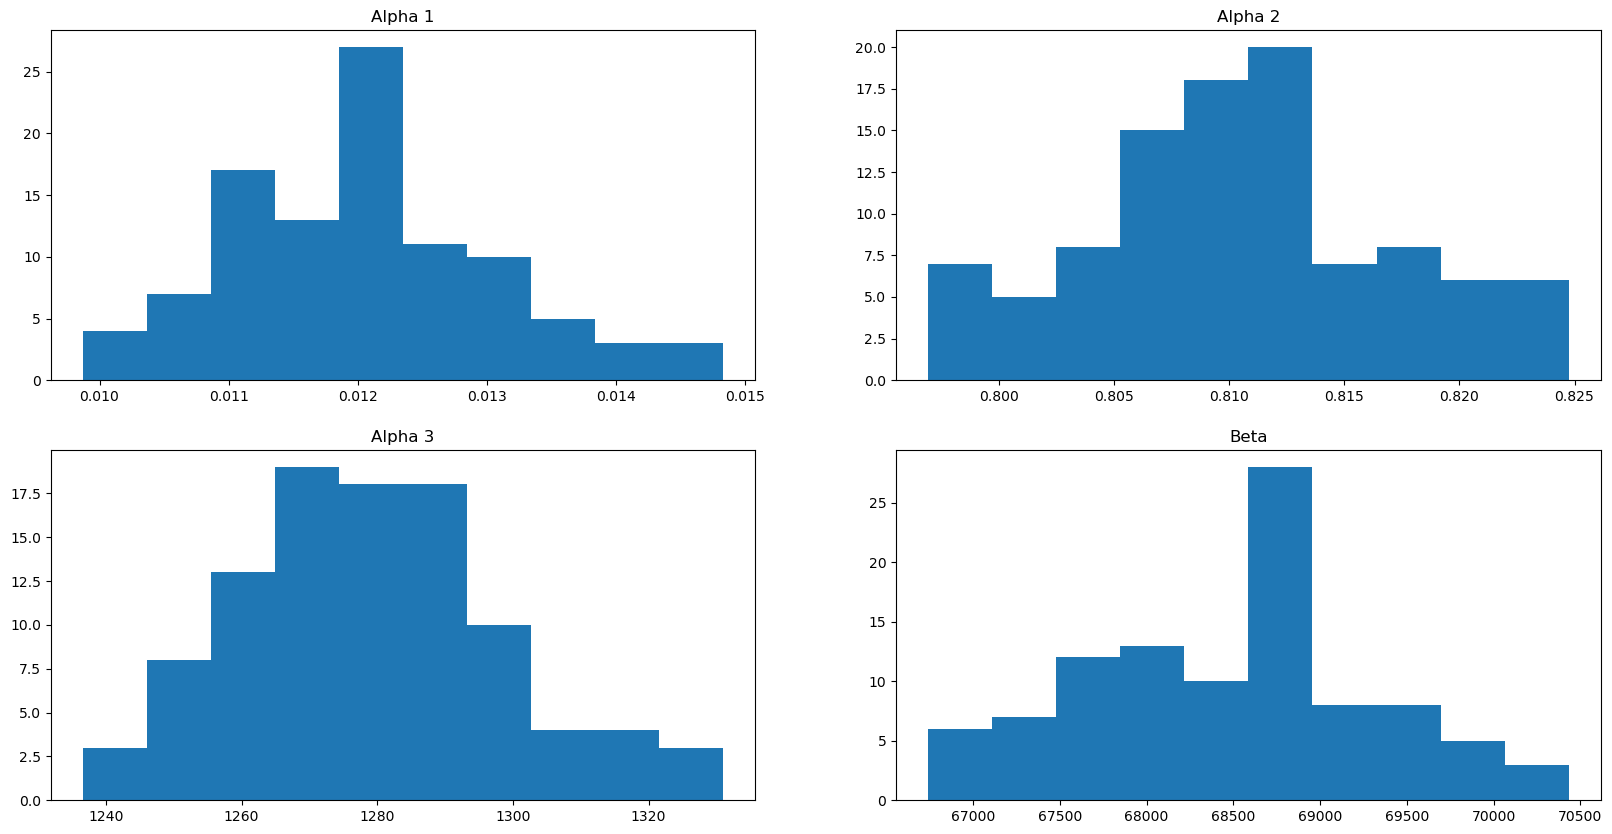

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(post_2.alpha_1)
plt.title('Alpha 1')

plt.subplot(2,2,2)
plt.hist(post_2.alpha_2)
plt.title('Alpha 2')

plt.subplot(2,2,3)
plt.hist(post_2.alpha_3)
plt.title('Alpha 3')

plt.subplot(2,2,4)
plt.hist(post_2.beta)
plt.title('Beta')

plt.show()